In [35]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
import os
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import OpenEXR as exr, Imath
from tqdm import tqdm
from glob import glob
import cv2

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from utils.cloud import Cloud
from pose_est import PoseEst, create_rot_from_angle, transform_pc, extrinsics_from_rot_transl, get_params_from_rot_and_transl
from params_est import optim_step_ICP, optim_step_neighbors

In [37]:
plot_counter = 0

In [38]:
ksize = 10
gt_extrinsics_dir = f'../data/synthetic/stylized-ww01-plane/blender_render_depth4_3x_more_frames_/'
gt_depth_dir = '../data/synthetic/stylized-ww01-plane/blender_render_depth4_3x_more_frames_'
shared_K_path = f'../data/synthetic/stylized-ww01-plane/blender_render_depth4_3x_more_frames_/K_0.txt'

In [39]:
K = torch.tensor(np.loadtxt(shared_K_path)).double()

In [40]:
K

tensor([[2.6667e+03, 0.0000e+00, 9.6000e+02],
        [0.0000e+00, 2.6667e+03, 5.4000e+02],
        [0.0000e+00, 0.0000e+00, 1.0000e+00]], dtype=torch.float64)

In [41]:
def load_data(depth_dir, gt_extrinsics_dir, indices, gt_depth_dir=None):
    # indices: array-like of int
    depth_all, RT_all, gt_depth_all = [], [], []
    for ind in indices:
        depth = np.load(os.path.join(depth_dir, f'{ind}.npy'))[..., 0]
        RT = np.loadtxt(os.path.join(gt_extrinsics_dir, f'RT_{ind}.txt'))
        depth_all.append(depth)
        RT_all.append(RT)
        if gt_depth_dir is not None:
            gt_depth = np.load(os.path.join(gt_depth_dir, f'{ind}.npy'))
            if len(gt_depth.shape) == 3 and gt_depth.shape[2] == 1:
                gt_depth = gt_depth[..., 0]
            gt_depth_all.append(gt_depth)
    
    depth_all = torch.tensor(np.stack(depth_all)).double()
    RT_all = torch.tensor(np.stack(RT_all)).double()
    if gt_depth_dir is not None:
        gt_depth_all = torch.tensor(np.stack(gt_depth_all)).double()
        return depth_all, RT_all, gt_depth_all
    return depth_all, RT_all

In [42]:
def corrupt_depth(depth, sigma=0.1):
    mask = (depth != depth.max())
    depth_new = depth.clone()
    depth_new[mask] += (np.random.randn(*depth_new.shape) * sigma)[mask]
    return depth_new

In [20]:
depth, extr, gt_depth = load_data(gt_depth_dir, gt_extrinsics_dir, indices=[10, 50], gt_depth_dir=gt_depth_dir)
#depth = corrupt_depth(depth, sigma=0.1)

In [9]:
depth[0].min(), depth[0].max()

(tensor(6.1295, dtype=torch.float64), tensor(15., dtype=torch.float64))

In [10]:
gt_depth[0].min(), gt_depth[0].max()

(tensor(6.1523, dtype=torch.float64), tensor(15., dtype=torch.float64))

In [11]:
depth[1].min(), depth[1].max()

(tensor(6.1591, dtype=torch.float64), tensor(15., dtype=torch.float64))

In [12]:
depth.shape, gt_depth.shape

(torch.Size([2, 1080, 1920]), torch.Size([2, 1080, 1920]))

### Testing visualization

In [21]:
pc1 = Cloud.from_tensors(depth[0], K, extr[0], ignore='max')

In [22]:
pc1.points

tensor([[ 0.7028, -0.3325,  6.2891],
        [ 0.7052, -0.3325,  6.2891],
        [ 0.7071, -0.3323,  6.2852],
        ...,
        [ 0.0399,  0.8502,  6.6484],
        [ 0.0424,  0.8502,  6.6484],
        [ 0.0449,  0.8507,  6.6523]], dtype=torch.float64)

In [43]:
def visualize_pcd(*cloud_objs):
    all_pc_o3d = []
    for cloud in cloud_objs:
        cloud_pts = cloud.points.cpu().data.numpy()
        pc_o3d = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(cloud_pts))
        all_pc_o3d.append(pc_o3d)
    o3d.visualization.draw_geometries(all_pc_o3d)

In [24]:
visualize_pcd(pc1)

### Testing params estimation (ICP correspondence set till convergence + LM till convergence)

In [16]:
depth, extr, gt_depth = load_data(gt_depth_dir, gt_extrinsics_dir, indices=[80, 120], gt_depth_dir=gt_depth_dir)
depth = corrupt_depth(depth, sigma=0.01)

In [17]:
pc0 = Cloud.from_tensors(depth[0], K, torch.eye(4), ignore='max')
# pc1 = Cloud.from_tensors(depth[1], K, torch.eye(4), ignore='max')
# pc0 = Cloud.from_tensors(gt_depth[0], K, torch.eye(4), ignore='max')
pc1 = Cloud.from_tensors(gt_depth[1], K, torch.eye(4), ignore='max')

In [18]:
visualize_pcd(pc0, pc1)

In [19]:
# optimization step & pc0 update:

params = optim_step_ICP(pc0, pc1, max_iter=100, icp_max_iter=30, verbose=1)
transl, angle = params.split([3, 3], dim=-1)
rot = create_rot_from_angle(angle.unsqueeze(0)).squeeze(0)
pc0.points = transform_pc(pc0.points, rot, transl).squeeze(1)
params

Correspondence set estimation...


KeyboardInterrupt: 

In [61]:
visualize_pcd(pc0, pc1)

In [62]:
transl

tensor([-1.8027,  0.0821, -0.0754], dtype=torch.float64)

In [63]:
extrinsics_from_rot_transl(rot, transl)

tensor([[ 0.9647, -0.0272,  0.2619, -1.8027],
        [ 0.0305,  0.9995, -0.0084,  0.0821],
        [-0.2615,  0.0161,  0.9651, -0.0754],
        [ 0.0000,  0.0000,  0.0000,  1.0000]], dtype=torch.float64)

In [64]:
extr[1] @ torch.inverse(extr[0])

tensor([[ 0.9645, -0.0230,  0.2631, -1.8127],
        [ 0.0252,  0.9997, -0.0051,  0.0583],
        [-0.2629,  0.0116,  0.9647, -0.0723],
        [ 0.0000,  0.0000,  0.0000,  1.0000]], dtype=torch.float64)

### Testing params estimation ((ICP correspondence set 1 iteration + LM 1 iteration) x N_iter)

In [44]:
depth, extr, gt_depth = load_data(gt_depth_dir, gt_extrinsics_dir, indices=[80, 120], gt_depth_dir=gt_depth_dir)
depth = corrupt_depth(depth, sigma=0.01)

In [45]:
pc0 = Cloud.from_tensors(depth[0], K, torch.eye(4), ignore='max')
# pc1 = Cloud.from_tensors(depth[1], K, torch.eye(4), ignore='max')
# pc0 = Cloud.from_tensors(gt_depth[0], K, torch.eye(4), ignore='max')
pc1 = Cloud.from_tensors(gt_depth[1], K, torch.eye(4), ignore='max')

In [46]:
visualize_pcd(pc0, pc1)

In [47]:
def loss_T(T_estim, extr_first, extr_second):
    gt_rel_extr = extr_second @ torch.inverse(extr_first)
    loss_val = ((gt_rel_extr - T_estim) ** 2).sum()
    return loss_val

In [48]:
def loss_params(pred_params, extr_first, extr_second):
    gt_rel_extr = extr_second @ torch.inverse(extr_first)
    gt_params = get_params_from_rot_and_transl(gt_rel_extr[:3, :3], gt_rel_extr[:3, 3])
    loss_val = ((pred_params - gt_params) ** 2).sum()
    return loss_val

In [49]:
gradslam_iter = 30

T = torch.eye(4).double()
for i in tqdm(range(gradslam_iter)):
    params_upd = optim_step_neighbors(pc0, pc1, max_iter=10, neighbors_take_each=1000, verbose=0)
    transl_upd, angle_upd = params_upd.split([3, 3], dim=-1)
    rot_upd = create_rot_from_angle(angle_upd.unsqueeze(0)).squeeze(0)
    pc0.points = transform_pc(pc0.points, rot_upd, transl_upd).squeeze(1)
    
    T_upd = extrinsics_from_rot_transl(rot_upd, transl_upd).double()
    T = T_upd @ T
    rot, transl = T[:3, :3], T[:3, 3]
    params = get_params_from_rot_and_transl(rot, transl)
    # print('loss', loss_T(T, extr[0], extr[1]))
    print('loss', loss_params(params, extr[0], extr[1]))

params

  0%|          | 0/30 [00:00<?, ?it/s]

Correspondence set estimation...


  0%|          | 0/30 [00:01<?, ?it/s]


NameError: name 'n_pts_A' is not defined

### GradOdometry

In [26]:
depth, extr, gt_depth = load_data(gt_depth_dir, gt_extrinsics_dir, indices=[80, 100], gt_depth_dir=gt_depth_dir)
depth = corrupt_depth(depth, sigma=0.3)
# depth = depth.requires_grad_()
depth_first = depth[0].clone()
depth_second = gt_depth[1].clone()
_ = depth_first.requires_grad_()

In [27]:
depth_first.min(), depth_first.max()

(tensor(5.1976, dtype=torch.float64, grad_fn=<MinBackward1>),
 tensor(15., dtype=torch.float64, grad_fn=<MaxBackward1>))

In [28]:
pc0 = Cloud.from_tensors(depth_first, K, torch.eye(4), ignore='max')
# pc1 = Cloud.from_tensors(depth_second, K, torch.eye(4), ignore='max')
# pc0 = Cloud.from_tensors(gt_depth[0], K, torch.eye(4), ignore='max')
pc1 = Cloud.from_tensors(gt_depth[1], K, torch.eye(4), ignore='max')

In [29]:
gt_pc0 = Cloud.from_tensors(gt_depth[0], K, torch.eye(4), ignore='max')
gt_pc1 = Cloud.from_tensors(gt_depth[1], K, torch.eye(4), ignore='max')

In [30]:
# pc0.mask = gt_pc0.mask
# pc1.mask = gt_pc1.mask
# pc0.update_data(pc0.depth, pc0.intrinsic, pc0.extrinsic, update_mask=False)
# pc0.update_data(pc1.depth, pc1.intrinsic, pc1.extrinsic, update_mask=False)

In [31]:
# visualize_pcd(pc0, pc1)
visualize_pcd(pc0)

In [32]:
def loss_T(T_estim, extr_first, extr_second):
    gt_rel_extr = extr_second @ torch.inverse(extr_first)
    loss_val = ((gt_rel_extr - T_estim) ** 2).sum()
    return loss_val

In [33]:
def loss_params(pred_params, extr_first, extr_second):
    gt_rel_extr = extr_second @ torch.inverse(extr_first)
    gt_params = get_params_from_rot_and_transl(gt_rel_extr[:3, :3], gt_rel_extr[:3, 3])
    loss_val = ((pred_params - gt_params) ** 2).sum()
    return loss_val

In [34]:
visualize_pcdlam_iter = 30
internal_iter = 10
opt = optim.Adam([depth_first], lr=3e-3)

depth_history = []
loss_history = []
internal_loss_history = []
l1_depth_history = []
l1_xyz_history = []

depth_first_img = depth_first.cpu().data.numpy()
depth_first_img_gt = gt_depth[0].cpu().data.numpy()
depth_history.append(depth_first_img)
# plt.figure(figsize=(10, 5))
# plt.imshow(depth_first_img, cmap=plt.cm.Greys_r)
# plt.colorbar()
# plt.show()
print('L1 between depth_first pic with motion blur and GT:', (np.abs(depth_first_img - depth_first_img_gt).mean()))
print('L1 between pc0 xyz and GT pc0 xyz:', (torch.abs(pc0.points - gt_pc0.points).mean()))

for i in tqdm(range(gradslam_iter)):
    pc0 = Cloud.from_tensors(depth_first, K, torch.eye(4), ignore='max')
    pc1 = Cloud.from_tensors(depth_second, K, torch.eye(4), ignore='max')
    
    T = torch.eye(4).double()
    
    # visualize_pcd(pc0)
  
    for j in range(internal_iter):
        # params_upd = optim_step_ICP(pc0, pc1, max_iter=10, icp_max_iter=1, verbose=0)
        params_upd = optim_step_neighbors(pc0, pc1, max_iter=10, neighbors_take_each=1000, verbose=0)
        transl_upd, angle_upd = params_upd.split([3, 3], dim=-1)
        rot_upd = create_rot_from_angle(angle_upd.unsqueeze(0)).squeeze(0)
        pc0.points = transform_pc(pc0.points, rot_upd, transl_upd).squeeze(1)

        T_upd = extrinsics_from_rot_transl(rot_upd, transl_upd).double()
        T = T_upd @ T
        rot, transl = T[:3, :3], T[:3, 3]
        params = get_params_from_rot_and_transl(rot, transl)
        # print('loss', loss_T(T, extr[0], extr[1]))
        # print('loss', loss_params(params, extr[0], extr[1]))
        loss_val = loss_params(params, extr[0], extr[1]).detach()
        internal_loss_history.append(loss_val.item())
        print('loss', loss_val)
    
    opt.zero_grad()
    loss_val = loss_params(params, extr[0], extr[1])
    loss_history.append(loss_val.item())
    print('loss', loss_val)
    loss_val.backward()
    opt.step()
    
#     if i % 5 == 0:
#         visualize_pcd(pc0, pc1)
    
    depth_first_img = depth_first.cpu().data.numpy()
    depth_first_img_gt = gt_depth[0].cpu().data.numpy()
    depth_history.append(depth_first_img)
#     plt.figure(figsize=(10, 5))
#     plt.imshow(depth_first_img, cmap=plt.cm.Greys_r)
#     plt.colorbar()
#     plt.show()
    l1_depth_history.append(np.abs(depth_first_img - depth_first_img_gt).mean())
    l1_xyz_history.append(torch.abs(pc0.points - gt_pc0.points).mean())
    print('L1 between depth_first pic with motion blur and GT:', (np.abs(depth_first_img - depth_first_img_gt).mean()))
    print('L1 between pc0 xyz and GT pc0 xyz:', (torch.abs(pc0.points - gt_pc0.points).mean()))

  0%|          | 0/30 [00:00<?, ?it/s]

L1 between depth_first pic with motion blur and GT: 0.01704908272121904
L1 between pc0 xyz and GT pc0 xyz: tensor(0.0887, dtype=torch.float64, grad_fn=<MeanBackward0>)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.7935, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.7613, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.7356, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.7408, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.7382, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.7415, dtype=t

  3%|▎         | 1/30 [00:23<11:32, 23.89s/it]

L1 between depth_first pic with motion blur and GT: 0.017049054705269056
L1 between pc0 xyz and GT pc0 xyz: tensor(0.1039, dtype=torch.float64, grad_fn=<MeanBackward0>)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.7699, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.7425, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.7144, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.7063, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.6967, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.6865, dtype=

  7%|▋         | 2/30 [00:47<11:08, 23.88s/it]

L1 between depth_first pic with motion blur and GT: 0.017049028519384085
L1 between pc0 xyz and GT pc0 xyz: tensor(0.1034, dtype=torch.float64, grad_fn=<MeanBackward0>)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.7569, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.7232, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.6910, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.6805, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.6521, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.6458, dtype=

 10%|█         | 3/30 [01:10<10:35, 23.55s/it]

L1 between depth_first pic with motion blur and GT: 0.017049005190462662
L1 between pc0 xyz and GT pc0 xyz: tensor(0.1033, dtype=torch.float64, grad_fn=<MeanBackward0>)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.7254, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.6911, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.6643, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.6466, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.6245, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.6180, dtype=

 13%|█▎        | 4/30 [01:33<10:06, 23.33s/it]

L1 between depth_first pic with motion blur and GT: 0.017048982031300307
L1 between pc0 xyz and GT pc0 xyz: tensor(0.1035, dtype=torch.float64, grad_fn=<MeanBackward0>)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.6990, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.6641, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.6299, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.5998, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.5939, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.5796, dtype=

 17%|█▋        | 5/30 [01:56<09:38, 23.15s/it]

L1 between depth_first pic with motion blur and GT: 0.01704895889394575
L1 between pc0 xyz and GT pc0 xyz: tensor(0.1038, dtype=torch.float64, grad_fn=<MeanBackward0>)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.6807, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.6381, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.6071, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.5748, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.5507, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.5383, dtype=t

 20%|██        | 6/30 [02:19<09:14, 23.10s/it]

L1 between depth_first pic with motion blur and GT: 0.01704893581206959
L1 between pc0 xyz and GT pc0 xyz: tensor(0.1046, dtype=torch.float64, grad_fn=<MeanBackward0>)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.7021, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.6267, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.5903, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.5452, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.5300, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.5270, dtype=t

 23%|██▎       | 7/30 [02:41<08:45, 22.85s/it]

L1 between depth_first pic with motion blur and GT: 0.01704891478917381
L1 between pc0 xyz and GT pc0 xyz: tensor(0.1043, dtype=torch.float64, grad_fn=<MeanBackward0>)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.6828, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.5985, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.5612, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.5136, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.4947, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.4935, dtype=t

 27%|██▋       | 8/30 [03:02<08:14, 22.47s/it]

L1 between depth_first pic with motion blur and GT: 0.017048894711389814
L1 between pc0 xyz and GT pc0 xyz: tensor(0.1051, dtype=torch.float64, grad_fn=<MeanBackward0>)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.6705, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.5906, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.5334, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.4810, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.4615, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.4592, dtype=

 30%|███       | 9/30 [03:24<07:48, 22.29s/it]

L1 between depth_first pic with motion blur and GT: 0.017048877010840745
L1 between pc0 xyz and GT pc0 xyz: tensor(0.1047, dtype=torch.float64, grad_fn=<MeanBackward0>)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.6523, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.5671, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.5081, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.4519, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.4343, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.4242, dtype=

 33%|███▎      | 10/30 [03:48<07:32, 22.61s/it]

L1 between depth_first pic with motion blur and GT: 0.017048862860640935
L1 between pc0 xyz and GT pc0 xyz: tensor(0.1049, dtype=torch.float64, grad_fn=<MeanBackward0>)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.6377, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.5454, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.4857, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.4321, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.4081, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.3891, dtype=

 37%|███▋      | 11/30 [04:10<07:08, 22.56s/it]

L1 between depth_first pic with motion blur and GT: 0.01704885202534995
L1 between pc0 xyz and GT pc0 xyz: tensor(0.1057, dtype=torch.float64, grad_fn=<MeanBackward0>)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.6196, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.5184, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.4504, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.3941, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.3868, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.3698, dtype=t

 40%|████      | 12/30 [04:34<06:53, 22.99s/it]

L1 between depth_first pic with motion blur and GT: 0.017048843838646757
L1 between pc0 xyz and GT pc0 xyz: tensor(0.1059, dtype=torch.float64, grad_fn=<MeanBackward0>)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.6001, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.4978, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.4198, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.3687, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.3350, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.3072, dtype=

 43%|████▎     | 13/30 [05:08<07:28, 26.39s/it]

L1 between depth_first pic with motion blur and GT: 0.017048835927820707
L1 between pc0 xyz and GT pc0 xyz: tensor(0.1067, dtype=torch.float64, grad_fn=<MeanBackward0>)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.5759, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.4734, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.3849, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.3478, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.3116, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.2856, dtype=

 47%|████▋     | 14/30 [05:37<07:15, 27.19s/it]

L1 between depth_first pic with motion blur and GT: 0.017048832488065175
L1 between pc0 xyz and GT pc0 xyz: tensor(0.1072, dtype=torch.float64, grad_fn=<MeanBackward0>)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.5501, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.4390, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.3525, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.3338, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.2918, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.2714, dtype=

 50%|█████     | 15/30 [06:22<08:05, 32.40s/it]

L1 between depth_first pic with motion blur and GT: 0.017048834478769204
L1 between pc0 xyz and GT pc0 xyz: tensor(0.1068, dtype=torch.float64, grad_fn=<MeanBackward0>)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.5358, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.4215, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.3368, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.3117, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.2682, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.2461, dtype=

 53%|█████▎    | 16/30 [07:03<08:08, 34.86s/it]

L1 between depth_first pic with motion blur and GT: 0.01704884136069387
L1 between pc0 xyz and GT pc0 xyz: tensor(0.1070, dtype=torch.float64, grad_fn=<MeanBackward0>)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.5254, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.4018, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.3194, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.2703, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.2389, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.2189, dtype=t

 57%|█████▋    | 17/30 [07:49<08:18, 38.34s/it]

L1 between depth_first pic with motion blur and GT: 0.017048849656099912
L1 between pc0 xyz and GT pc0 xyz: tensor(0.1070, dtype=torch.float64, grad_fn=<MeanBackward0>)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.5337, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.3895, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.3039, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.2563, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.2255, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.2021, dtype=

 60%|██████    | 18/30 [08:30<07:50, 39.19s/it]

L1 between depth_first pic with motion blur and GT: 0.01704886130020427
L1 between pc0 xyz and GT pc0 xyz: tensor(0.1072, dtype=torch.float64, grad_fn=<MeanBackward0>)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.5240, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.3759, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.2893, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.2416, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.2092, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.1881, dtype=t

 63%|██████▎   | 19/30 [09:02<06:45, 36.89s/it]

L1 between depth_first pic with motion blur and GT: 0.017048872332685473
L1 between pc0 xyz and GT pc0 xyz: tensor(0.1072, dtype=torch.float64, grad_fn=<MeanBackward0>)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.5160, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.3683, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.2931, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.2336, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.1978, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.1793, dtype=

 67%|██████▋   | 20/30 [09:38<06:07, 36.73s/it]

L1 between depth_first pic with motion blur and GT: 0.01704888292177195
L1 between pc0 xyz and GT pc0 xyz: tensor(0.1076, dtype=torch.float64, grad_fn=<MeanBackward0>)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.5122, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.3566, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.2627, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.2104, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.1778, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.1586, dtype=t

 70%|███████   | 21/30 [10:13<05:26, 36.32s/it]

L1 between depth_first pic with motion blur and GT: 0.017048893578570628
L1 between pc0 xyz and GT pc0 xyz: tensor(0.1101, dtype=torch.float64, grad_fn=<MeanBackward0>)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.4985, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.3473, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.2540, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.1979, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.1682, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.1490, dtype=

 73%|███████▎  | 22/30 [10:57<05:08, 38.58s/it]

L1 between depth_first pic with motion blur and GT: 0.01704890421707801
L1 between pc0 xyz and GT pc0 xyz: tensor(0.1110, dtype=torch.float64, grad_fn=<MeanBackward0>)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.4835, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.3288, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.2371, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.1868, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.1507, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.1304, dtype=t

 77%|███████▋  | 23/30 [11:39<04:35, 39.41s/it]

L1 between depth_first pic with motion blur and GT: 0.017048914735298577
L1 between pc0 xyz and GT pc0 xyz: tensor(0.1103, dtype=torch.float64, grad_fn=<MeanBackward0>)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.4748, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.3157, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.2277, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.1775, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.1394, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.1213, dtype=

 80%|████████  | 24/30 [12:25<04:09, 41.53s/it]

L1 between depth_first pic with motion blur and GT: 0.01704892508548574
L1 between pc0 xyz and GT pc0 xyz: tensor(0.1108, dtype=torch.float64, grad_fn=<MeanBackward0>)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.4683, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.3066, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.2159, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.1681, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.1375, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.1197, dtype=t

 83%|████████▎ | 25/30 [12:57<03:13, 38.62s/it]

L1 between depth_first pic with motion blur and GT: 0.017048935248618904
L1 between pc0 xyz and GT pc0 xyz: tensor(0.1112, dtype=torch.float64, grad_fn=<MeanBackward0>)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.4520, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.2914, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.2083, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.1585, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.1322, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.1202, dtype=

 87%|████████▋ | 26/30 [13:32<02:30, 37.59s/it]

L1 between depth_first pic with motion blur and GT: 0.017048946591220523
L1 between pc0 xyz and GT pc0 xyz: tensor(0.1119, dtype=torch.float64, grad_fn=<MeanBackward0>)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.4608, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.3012, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.2115, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.1509, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.1180, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0991, dtype=

 90%|█████████ | 27/30 [14:13<01:55, 38.42s/it]

L1 between depth_first pic with motion blur and GT: 0.017048960009698414
L1 between pc0 xyz and GT pc0 xyz: tensor(0.1126, dtype=torch.float64, grad_fn=<MeanBackward0>)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.4692, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.2950, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.2030, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.1438, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.1125, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0971, dtype=

 93%|█████████▎| 28/30 [14:47<01:14, 37.23s/it]

L1 between depth_first pic with motion blur and GT: 0.017048973258365966
L1 between pc0 xyz and GT pc0 xyz: tensor(0.1131, dtype=torch.float64, grad_fn=<MeanBackward0>)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.4538, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.2837, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.2025, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.1379, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.1037, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0865, dtype=

 97%|█████████▋| 29/30 [15:21<00:36, 36.29s/it]

L1 between depth_first pic with motion blur and GT: 0.01704898670774357
L1 between pc0 xyz and GT pc0 xyz: tensor(0.1133, dtype=torch.float64, grad_fn=<MeanBackward0>)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.4433, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.2782, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.1950, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.1341, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.1028, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0883, dtype=t

100%|██████████| 30/30 [15:54<00:00, 31.83s/it]

L1 between depth_first pic with motion blur and GT: 0.017049000486638634
L1 between pc0 xyz and GT pc0 xyz: tensor(0.1145, dtype=torch.float64, grad_fn=<MeanBackward0>)


In [20]:
plot_counter += 1

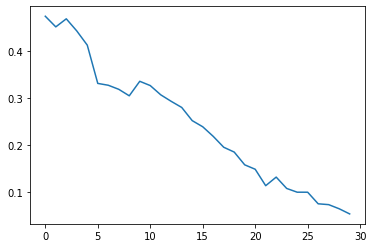

In [21]:
plt.plot(loss_history)
plt.savefig(f'loss_history_{plot_counter}.pdf')
np.save(f'loss_history_{plot_counter}.npy', loss_history)

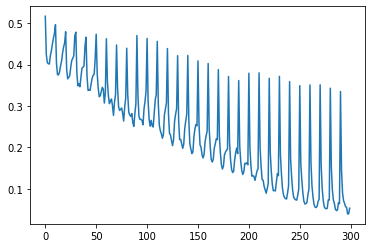

In [22]:
plt.plot(internal_loss_history)
plt.savefig(f'internal_loss_history_{plot_counter}.pdf')
np.save(f'internal_loss_history_{plot_counter}.npy', loss_history)

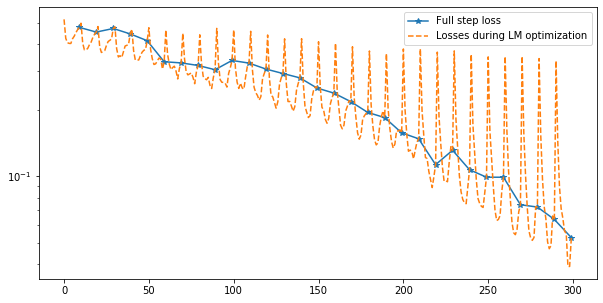

In [23]:
plt.figure(figsize=(10, 5))
plt.semilogy(np.arange(len(loss_history)) * internal_iter + internal_iter - 1, loss_history, '-*', label='Full step loss')
plt.semilogy(np.arange(len(internal_loss_history)), internal_loss_history, '--', label='Losses during LM optimization')
plt.legend()
plt.savefig(f'internal_and_full_{plot_counter}.pdf')
plt.savefig(f'internal_and_full_{plot_counter}.png')

In [24]:
visualize_pcd(pc0)

In [72]:
depth_first.min(), depth_first.max()

(tensor(6.1311, dtype=torch.float64, grad_fn=<MinBackward1>),
 tensor(15., dtype=torch.float64, grad_fn=<MaxBackward1>))

In [73]:
depth_first_img_gt.min(), depth_first_img_gt.max()

(6.15234375, 15.0)

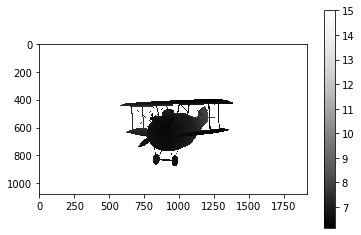

In [56]:
visualize_pcd(pc0, pc1)